In [1]:
from paretoCardinalityTeams import *

import shutil
import matplotlib as mpl

# Enable LaTeX rendering if available (fallback to Matplotlib text otherwise)
if shutil.which("latex"):
    mpl.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
        "text.latex.preamble": r"\usepackage{amsmath}\usepackage{amssymb}",
    })
else:
    mpl.rcParams.update({"text.usetex": False})

#Import datasets
#IMDB
imdb_experts_1, imdb_tasks_1, imdb_costs_1, imdb_graphmat_1 = import_pickled_datasets('imdb', 1)
imdb_experts_2, imdb_tasks_2, imdb_costs_2, imdb_graphmat_2 = import_pickled_datasets('imdb', 2)
imdb_experts_3, imdb_tasks_3, imdb_costs_3, imdb_graphmat_3 = import_pickled_datasets('imdb', 3)

#Bibsonomy
bbsm_experts_1, bbsm_tasks_1, bbsm_costs_1, bbsm_graphmat_1 = import_pickled_datasets('bbsm', 1)
bbsm_experts_2, bbsm_tasks_2, bbsm_costs_2, bbsm_graphmat_2 = import_pickled_datasets('bbsm', 2)
bbsm_experts_3, bbsm_tasks_3, bbsm_costs_3, bbsm_graphmat_3 = import_pickled_datasets('bbsm', 3)

#Freelancer
fl_experts_1, fl_tasks_1, fl_costs_1, fl_graphmat_1 = import_pickled_datasets('freelancer', 1)
fl_experts_2, fl_tasks_2, fl_costs_2, fl_graphmat_2 = import_pickled_datasets('freelancer', 2)

2026-02-01 14:36:41,096 |INFO: Imported imdb experts, Num Experts: 200
2026-02-01 14:36:41,097 |INFO: Imported imdb tasks, Num Tasks: 300
2026-02-01 14:36:41,099 |INFO: Imported imdb costs, Num Costs: 200
2026-02-01 14:36:41,102 |INFO: Imported imdb graph matrix, Shape: (1000, 1000)

2026-02-01 14:36:41,103 |INFO: Imported imdb experts, Num Experts: 400
2026-02-01 14:36:41,105 |INFO: Imported imdb tasks, Num Tasks: 300
2026-02-01 14:36:41,105 |INFO: Imported imdb costs, Num Costs: 400
2026-02-01 14:36:41,112 |INFO: Imported imdb graph matrix, Shape: (3000, 3000)

2026-02-01 14:36:41,114 |INFO: Imported imdb experts, Num Experts: 1000
2026-02-01 14:36:41,115 |INFO: Imported imdb tasks, Num Tasks: 300
2026-02-01 14:36:41,116 |INFO: Imported imdb costs, Num Costs: 1000
2026-02-01 14:36:41,127 |INFO: Imported imdb graph matrix, Shape: (4000, 4000)

2026-02-01 14:36:41,129 |INFO: Imported bbsm experts, Num Experts: 250
2026-02-01 14:36:41,130 |INFO: Imported bbsm tasks, Num Tasks: 300
2026-

In [2]:
def findApproximateParetoSolutions(tasks_list, experts_list, size_univ, numTasks, k_max, numExperts, dataset_name=""):
    '''
    Run algorithms over multiple tasks, aggregate results, and plot mean +/- std.
    Parameters:
    - tasks_list: List of tasks (each task is a list of required skills) 
    - experts_list: List of experts (each expert is a list of skills)
    - size_univ: Size of the universe of skills
    - numTasks: Number of tasks to evaluate
    - k_max: Maximum team size (cardinality)
    - numExperts: Number of experts to consider from experts_list
    - dataset_name: Name of the dataset for plotting
    '''
    algo_names = ["ParetoGreedy-Cardinality", "TopK", "Random"]

    # containers across tasks
    all_coverages = {alg: [] for alg in algo_names}
    all_runtimes = {alg: [] for alg in algo_names}

    # iterate tasks
    for task_index in range(numTasks):
        # per-task containers
        task_coverages = {alg: [] for alg in algo_names}
        task_runtimes = {alg: [] for alg in algo_names}

        # Initialize Pareto cardinality object
        paretoCard = paretoCardinalityTeams(task=tasks_list[task_index],
                                       n_experts=experts_list[:numExperts],  # assuming numExperts is defined
                                       size_univ=size_univ,
                                       k_max=k_max)

        # Pareto Greedy (Cardinality)
        _, _, _, runTime = paretoCard.greedyCardinality()
        coverages = []
        current_coverage = 0
        for k in range(1, k_max + 1):
            if k in paretoCard.kSolDict:
                current_coverage = paretoCard.kSolDict[k]['Coverage']
            coverages.append(current_coverage)
        task_coverages['ParetoGreedy-Cardinality'] = coverages
        task_runtimes['ParetoGreedy-Cardinality'] = runTime

        # Top K
        paretoCard2 = paretoCardinalityTeams(task=tasks_list[task_index],
                                        n_experts=experts_list[:numExperts],
                                        size_univ=size_univ,
                                        k_max=k_max)
        _, _, _, runTime = paretoCard2.top_k()
        coverages = [paretoCard2.kSolDict.get(k, {'Coverage': 0})['Coverage'] for k in range(1, k_max + 1)]
        task_coverages['TopK'] = coverages
        task_runtimes['TopK'] = runTime

        # Random
        paretoCard3 = paretoCardinalityTeams(task=tasks_list[task_index],
                                        n_experts=experts_list[:numExperts],
                                        size_univ=size_univ,
                                        k_max=k_max)
        _, _, _, runTime = paretoCard3.random_selection()
        coverages = [paretoCard3.kSolDict.get(k, {'Coverage': 0})['Coverage'] for k in range(1, k_max + 1)]
        task_coverages['Random'] = coverages
        task_runtimes['Random'] = runTime

        # convert per-task lists to numpy arrays and store
        for alg in algo_names:
            arr = np.array(task_coverages[alg], dtype=float)
            all_coverages[alg].append(arr)
            all_runtimes[alg].append(task_runtimes[alg])

    # compute mean and std across tasks for each algorithm
    mean_coverages = {}
    std_coverages = {}
    for alg in algo_names:
        stacked = np.vstack(all_coverages[alg])  # shape (numTasks, k_max)
        mean_coverages[alg] = np.mean(stacked, axis=0)
        std_coverages[alg] = np.std(stacked, axis=0) * 0.5

    # Plot mean coverage with shaded std band (consistent with influence formatting)
    colors = plt.get_cmap("tab10").colors
    linestyles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1))]
    markers = ['o', 's', '^', 'v', 'D']
    fig, ax = plt.subplots(figsize=(9, 5.5))
    for i, alg in enumerate(algo_names):
        mean = mean_coverages[alg]
        std = std_coverages[alg]
        is_pareto = alg in {"ParetoGreedy-Cardinality"}
        marker_size = 7 if is_pareto else 6
        line_style = '-' if is_pareto else ':'
        color = colors[i]
        marker = markers[i % len(markers)]
        zorder = 3
        if alg == "ParetoGreedy-Cardinality":
            color = colors[3]
            marker = "D"
            zorder = 4
        label = rf"\texttt{{{alg}}} (ours)" if is_pareto else rf"\texttt{{{alg}}}"
        ax.plot(range(1, k_max + 1), mean, label=label, color=color, linestyle=line_style, marker=marker, markersize=marker_size, markeredgewidth=1.1, markeredgecolor='k', linewidth=1.8, zorder=zorder)
        ax.fill_between(range(1, k_max + 1), np.clip(mean - std, 0, None), mean + std, color=color, alpha=0.18, zorder=2)

    ax.set_xlabel(r'Cardinality, $k$', fontsize=28)
    ax.set_ylabel(r'Task coverage, $\bar{f}$', fontsize=28)
    ax.set_title("")
    ax.grid(alpha=0.3)
    ax.tick_params(axis='both', labelsize=24)

    # Legend handles (saved separately)
    handles, labels = ax.get_legend_handles_labels()

    # Save figure
    from pathlib import Path
    base_dir = Path.cwd().resolve().parents[1]
    plots_dir = base_dir / "plots" / "cardinality"
    plots_dir.mkdir(parents=True, exist_ok=True)
    safe_name = (dataset_name or "dataset").replace(" ", "_")
    out_path = plots_dir / f"{safe_name}_cardinality.pdf"
    fig.savefig(out_path, bbox_inches="tight")

    # Save legend as separate PDF
    if handles:
        legend_out_path = plots_dir / "cardinality_legend.pdf"
        if not legend_out_path.exists():
            legend_fig = plt.figure(figsize=(8, 2))
            legend_fig.legend(handles, labels, loc='center', ncol=3, fontsize=22, frameon=True)
            legend_fig.savefig(legend_out_path, bbox_inches="tight")
            plt.close(legend_fig)

    plt.show()

    # Runtime summary (mean ± std)
    runtime_lines = ["Runtime summary (mean ± std, seconds):"]
    for alg in algo_names:
        mean_rt = float(np.mean(all_runtimes[alg])) if len(all_runtimes[alg]) > 0 else 0.0
        std_rt = float(np.std(all_runtimes[alg])) if len(all_runtimes[alg]) > 0 else 0.0
        runtime_lines.append(f"  - {alg}: {mean_rt:.3f} ± {std_rt:.3f}")
    logging.info("\n".join(runtime_lines))

    return None

### IMDB

2026-02-01 14:36:41,193 |INFO: Initialized Pareto Coverage - Cardinality Cost Instance, Task:[0, 1, 2, 3, 4, 5, 6, 7], Num Experts:75, k=15
2026-02-01 14:36:41,194 |INFO: Cardinality Greedy Solution for k_max:[[1, 4, 5, 7, 9], [0, 1, 3, 13, 14], [2, 3, 22], [3, 6]], Coverage:1.000, Runtime = 0.00 seconds
2026-02-01 14:36:41,195 |INFO: Initialized Pareto Coverage - Cardinality Cost Instance, Task:[0, 1, 2, 3, 4, 5, 6, 7], Num Experts:75, k=15
2026-02-01 14:36:41,196 |INFO: Top-k Solution for k_max:[[1, 4, 5, 7, 9], [1, 4, 5, 7, 15], [1, 3, 4, 18], [1, 2, 7, 16], [1, 3, 5], [1, 2, 3, 16], [1, 3, 4], [1, 3, 7], [1, 6, 7, 16], [2, 3, 4], [1, 4, 5], [1, 4, 7, 9], [1, 3, 6], [0, 1, 3], [1, 3, 7, 15]], Coverage:1.000, Runtime = 0.00 seconds
2026-02-01 14:36:41,197 |INFO: Initialized Pareto Coverage - Cardinality Cost Instance, Task:[0, 1, 2, 3, 4, 5, 6, 7], Num Experts:75, k=15
2026-02-01 14:36:41,242 |INFO: Random Selection Solution for k_max:[[1, 21], [1, 3, 7], [1, 2], [4, 7], [4, 6, 17], 

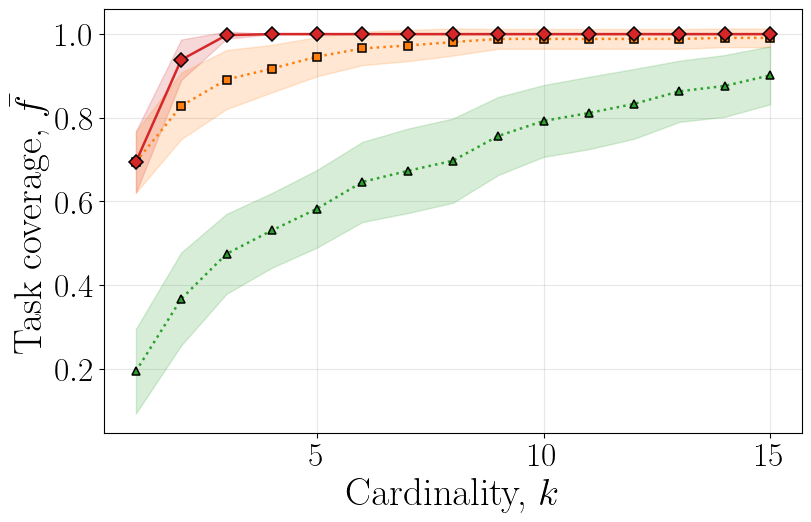

2026-02-01 14:36:42,388 |INFO: Runtime summary (mean ± std, seconds):
  - ParetoGreedy-Cardinality: 0.000 ± 0.000
  - TopK: 0.000 ± 0.000
  - Random: 0.001 ± 0.006


In [3]:
#Parameters
numTasks = 50  # number of tasks
k_max = 15 

numExperts = 75
findApproximateParetoSolutions(imdb_tasks_1, imdb_experts_1, 24, numTasks, k_max, numExperts, "IMDB-1")

2026-02-01 14:36:42,400 |INFO: Initialized Pareto Coverage - Cardinality Cost Instance, Task:[0, 1, 2, 3, 4, 5, 6, 7, 8], Num Experts:100, k=15
2026-02-01 14:36:42,402 |INFO: Cardinality Greedy Solution for k_max:[[0, 1, 2, 3, 7, 11, 12], [1, 5, 6], [0, 8], [0, 2, 4]], Coverage:1.000, Runtime = 0.00 seconds
2026-02-01 14:36:42,403 |INFO: Initialized Pareto Coverage - Cardinality Cost Instance, Task:[0, 1, 2, 3, 4, 5, 6, 7, 8], Num Experts:100, k=15
2026-02-01 14:36:42,404 |INFO: Top-k Solution for k_max:[[0, 1, 2, 3, 7, 11, 12], [1, 2, 3, 5, 13, 16], [0, 1, 2, 3], [1, 2, 4, 7], [1, 2, 4, 7, 11, 12], [1, 2, 3, 4, 9], [1, 3, 4, 5, 11], [0, 1, 2, 18], [0, 1, 5], [0, 2, 4], [0, 1, 4, 17], [0, 1, 7, 12], [2, 3, 7, 9, 12], [0, 5, 7, 11, 14], [0, 1, 2]], Coverage:0.778, Runtime = 0.00 seconds
2026-02-01 14:36:42,404 |INFO: Initialized Pareto Coverage - Cardinality Cost Instance, Task:[0, 1, 2, 3, 4, 5, 6, 7, 8], Num Experts:100, k=15
2026-02-01 14:36:42,405 |INFO: Random Selection Solution fo

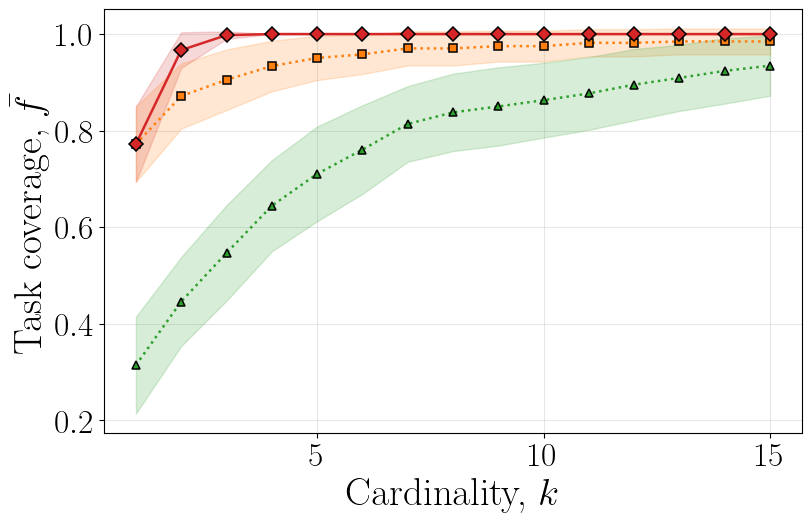

2026-02-01 14:36:42,912 |INFO: Runtime summary (mean ± std, seconds):
  - ParetoGreedy-Cardinality: 0.000 ± 0.000
  - TopK: 0.000 ± 0.000
  - Random: 0.000 ± 0.000


In [4]:
numExperts = 100
findApproximateParetoSolutions(imdb_tasks_2, imdb_experts_2, 24, numTasks, k_max, numExperts, "IMDB-2")

### Bibsonomy

2026-02-01 14:36:42,921 |INFO: Initialized Pareto Coverage - Cardinality Cost Instance, Task:[67, 51, 4, 52], Num Experts:150, k=15
2026-02-01 14:36:42,923 |INFO: Cardinality Greedy Solution for k_max:[[0, 34, 67, 4, 66, 71, 9, 42, 46, 18, 51, 52, 24, 26, 59]], Coverage:1.000, Runtime = 0.00 seconds
2026-02-01 14:36:42,925 |INFO: Initialized Pareto Coverage - Cardinality Cost Instance, Task:[67, 51, 4, 52], Num Experts:150, k=15
2026-02-01 14:36:42,926 |INFO: Top-k Solution for k_max:[[0, 34, 67, 4, 66, 71, 9, 42, 46, 18, 51, 52, 24, 26, 59], [0, 2, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 44, 45, 49, 51, 52, 53, 54, 55, 56, 57, 60, 61, 62, 63, 65, 68, 70, 74], [1, 4, 5, 10, 11, 13, 15, 17, 20, 21, 27, 28, 29, 30, 31, 32, 33, 44, 45, 51, 54, 56, 57, 59, 61, 66, 68, 70, 72], [0, 2, 4, 39, 9, 10, 46, 15, 18, 19, 51, 24, 27, 28, 63], [32, 1, 2, 3, 4, 64, 6, 7, 39, 13, 16, 48, 51], [64, 4, 5, 6, 6

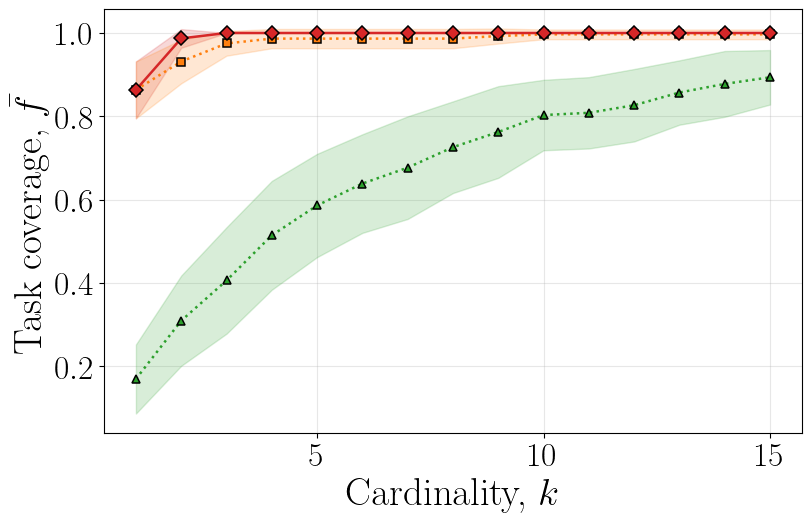

2026-02-01 14:36:43,521 |INFO: Runtime summary (mean ± std, seconds):
  - ParetoGreedy-Cardinality: 0.000 ± 0.000
  - TopK: 0.000 ± 0.000
  - Random: 0.000 ± 0.000


In [5]:
numExperts = 150
findApproximateParetoSolutions(bbsm_tasks_1, bbsm_experts_1, 75, numTasks, k_max, numExperts, "BBSM")

### Freelancer

2026-02-01 14:36:43,530 |INFO: Initialized Pareto Coverage - Cardinality Cost Instance, Task:[26, 42, 22, 44], Num Experts:50, k=15
2026-02-01 14:36:43,531 |INFO: Cardinality Greedy Solution for k_max:[[42, 22], [44, 22], [26, 20]], Coverage:1.000, Runtime = 0.00 seconds
2026-02-01 14:36:43,531 |INFO: Initialized Pareto Coverage - Cardinality Cost Instance, Task:[26, 42, 22, 44], Num Experts:50, k=15
2026-02-01 14:36:43,532 |INFO: Top-k Solution for k_max:[[42, 22], [42, 12, 22], [44, 22], [16, 22], [12, 22], [25, 22], [26, 20], [12, 13, 22], [25, 26], [24, 22], [4, 44], [27, 22], [24, 22, 14], [16, 25, 22], [48, 21, 5]], Coverage:1.000, Runtime = 0.00 seconds
2026-02-01 14:36:43,533 |INFO: Initialized Pareto Coverage - Cardinality Cost Instance, Task:[26, 42, 22, 44], Num Experts:50, k=15
2026-02-01 14:36:43,534 |INFO: Random Selection Solution for k_max:[[17, 49], [21, 5], [27, 22], [24, 36, 46], [12, 22], [16, 25, 22], [19, 5], [26, 20], [3, 31], [25, 26], [17, 14], [9, 30], [49, 37

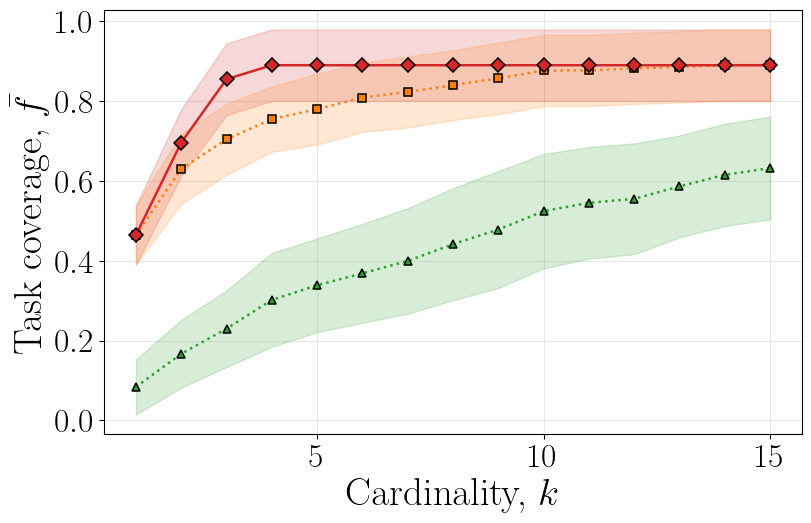

2026-02-01 14:36:44,026 |INFO: Runtime summary (mean ± std, seconds):
  - ParetoGreedy-Cardinality: 0.000 ± 0.000
  - TopK: 0.000 ± 0.000
  - Random: 0.000 ± 0.000


In [6]:
numExperts = 100
findApproximateParetoSolutions(fl_tasks_1, fl_experts_1, 50, numTasks, k_max, numExperts, "Freelancer")